# Lab 1: Introduction to curve fitting

In this exercise, we will explore fitting climate data using a simple linear least-squares model. The dataset consists of daily temperature records at Hubbard Brook New Hampshire, extending back more than 60 years. Our goal is to analyze the data for any signals of long term climate trends. The exercise is divided into two components. In the first component, you will divide into groups of 2 to 4, and work together through the coding problems below. In this section, you will set up and "invert" for your best fitting model using linear least squares. The second component is meant to be completed individually as homework, and will test your ability to analyze and interpret the results. 

All answers must be provided in this notebook (either as code block or in Markdown) in the boxes provided below each question. To turn in the assignment, save the completed notebook and send in the .ipynb file (do not export to pdf!) so that all the code can be run. The lab is worth a total of 100 points (70 for part 1, 30 for part 2), with a few possible bonus points. 

### Review of linear least-squares regression
$\color{green}{\text{*Note, this section is meant to review the material covered in the recorded lecture.}}$

One of the simplest aprroaches to curve fitting is linear least-squares regression. In this method, it is assumed that your data $\mathbf{d}$ can be modeled by a linear combination of some unknown model parameters $\mathbf{m}$. The most straightforward example of this is fitting a straight line to scattered data points. Mathematicaly, this can be written

$d_{i} = m_{1} + m_{2}x_{i}$

where $d_{i}$ is the value of the $i^{th}$ data point, $x_{i}$ is the value of the independent variable $x$ at index $i$, and $m_{1}$ and $m_{2}$ are your unknown "model parameters", which in this case represent the y-intercept and the slope of you best fitting line, respectively. This equation represents a matrix-vector system, which can be solved for the unknown model parameters. The individual elements of the matrix-vector system are shown below

$\begin{bmatrix} d_1 \\ d_2 \\ d_3 \\ \vdots \\ d_N \end{bmatrix} = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ 1 & x_3 \\ \vdots & \vdots \\ 1 & x_N \end{bmatrix} \begin{bmatrix} m_1 \\ m_2 \end{bmatrix} $

or, rewriting the data vector as $\mathbf{d}$, the data 'kernel' (also referred to as the sensitivity matrix) as $\mathbf{G}$, and the model vector as $\mathbf{m}$:

$\mathbf{d} = \mathbf{G} \mathbf{m} $

This equation is the foundation of linear inverse theory. It can be solved in a variety of ways, but here we will focus the "least-squares" solution, which is one of the most common. The least-squares solution is the solution that minimizes the sum of the squared residuals (i.e., the misfit between your model prediction and your data). Mathematically, the least squares solution to the matrix vector system above is given as

$\mathbf{m}^{lsq} = \left[ \mathbf{G}^T \mathbf{G} \right] ^{-1} \mathbf{G}^{T}\mathbf{d}$

where $\mathbf{m}^{lsq}$ is the solution vector, and the superscripts $^{T}$ and $^{-1}$ indicate the matrix transpose and inverse, respectively. In this exercise, we will perform these matrix operations using the python library numpy. 


### Extra resources
[Essence of Linear Alebgra, by ThreeBlueOneBrown](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab): Excellent visual overview of basic matrix and vector operations.

[pythoncheatsheet.org](https://www.pythoncheatsheet.org/): Handy resource for an overview of the python language.

[matplotlib users guide](https://matplotlib.org/stable/users/index.html): Official documentation of matplotlib, including many examples.

## Part 1, group exercise: Modeling 60+ years of climate data from the Hubbard Brook Experimental Forest

The Hubbard Brook Experimental Forest in the White Mountains of New Hampshire is a unique "natural laboratory" that has been used for ecological research since 1955. Starting shortly after its inception, continous records of many types of data have been made, including observations of temperature, hydrology (e.g., stream flow), soil geochemistry, and even plant and animal species inventories. This data provides an exceptional opportunity to study how the environment at a single location on Earth has changed in recent history, and can help inform us about how the planet responds to a changing climate.

Below, we will explore some of the Hubbard Brook time series data. In particular, we will analyze continuous temperature data that has been collected since 1957, and use this data to construct a simple model of how the temperature has changed during the time of this experiment. 

### Import statements
This coding exercise will utilze three commonly used python libraries; pandas, numpy, and matplotlib. In order to use them in your code you first need to 'import' them with the following statements.

In [2]:
import pandas as pd #toolbox for reading and manipulating spreadsheet data
import numpy as np #library for basic numerical operations
import matplotlib.pyplot as plt #plotting toolkit

### Loading the data with pandas
Pandas is a powerful python toolbox for reading, writing, and manipulating data in a variety of formats. Here, the data we will use is openly available through the [Hubbard Brook Data Catalog](https://hubbardbrook.org/d/hubbard-brook-data-catalog). We can access the data in "comma-separated value" format (.csv) directly through pandas. Below, a code segment is provided to read the data from the online catalog into a pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) object. The structure of this object basically consists of serveral named columns of data, which include the date ("date"), the name of the temperature recording station ("STA"), as well as the minimum, maximum, and average temperature recorded ("MIN", "MAX", and "AVE"). As you will see, the dataset consists of daily temperature records starting on January 1st, 1957, measured at several stations.

$\color{green}{\text{*Note, you are not expected to be an expert on pandas data structures. Here, all code segments required to download and extract the data are provided.}}$

In [3]:
url='https://pasta.lternet.edu/package/data/eml/knb-lter-hbr/59/9/9723086870f14b48409869f6c06d6aa8'
dset = pd.read_csv(url) #read data into a variable we will call "dset". The "type" of dset is a pandas DataFrame. 
print(dset.head()) #Show the first serveral lines of the data. 

         date STA   MAX   MIN   AVE  Flag
0  1957-01-01  HQ -12.0 -25.0 -18.0   NaN
1  1957-01-02  HQ -14.0 -24.0 -19.0   NaN
2  1957-01-03  HQ  -6.0 -19.0 -12.0   NaN
3  1957-01-04  HQ   0.0 -17.0  -8.0   NaN
4  1957-01-05  HQ  -6.0 -24.0 -15.0   NaN


Now that we have read in the data, and have an idea of how it's organized, we will select a subset of the data to analyze. In particular, we will work with the daily average temperature at station "STA1" from January 1, 1957, until December 31, 2019. The code block below will select the average temperate data from STA1 and assign it to variable d. Additionally, the date strings for this time period will be assigned to the variable "dates". Note the "sampling rate" is 1 sample per day.

In [4]:
indices = np.where(dset['STA'] == 'STA1')[0] #find the indices of the data that correspond to station "STA1"
d = dset.AVE[indices] #Average temperature data at STA1
dates = dset.date[indices] #date strings

### Plotting the data with matplotlib

###  <font color='red'>Question 1 (10 points) </font> 
#### Using matplotlib, write a block of code to plot the temperature time series at station STA1. Make sure to label the axes properly, with day number (starting with 0) on the x-axis, and temperature (in degrees C) on the y-axis. 

#### Bonus (3 pts): Instead of plotting the x-axis in terms of number of days since the beginning of the experiment, use the date strings that give the day in YYYY-MM-DD. Choose a reasonable increment for the labeling (e.g., every 10 years). *Hint*, you need to change the [x-ticks](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html) attribute. 

(0, 23511.0)

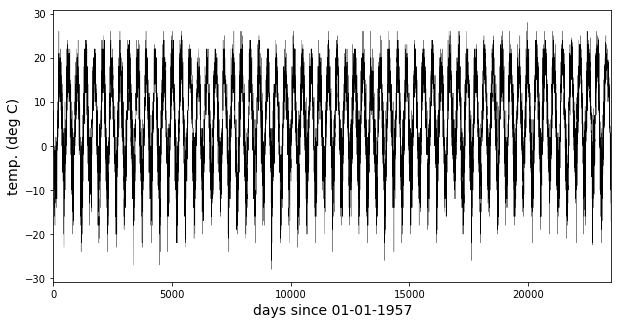

In [5]:
fig = plt.figure(figsize=[10,5])
t = np.linspace(0,len(d),len(d))
plt.plot(t,d,c='k',linewidth=0.25)
plt.xlabel('days since 01-01-1957',fontsize=14)
plt.ylabel('temp. (deg C)',fontsize=14)
plt.xlim([0,np.max(t)])

###  <font color='red'>Question 2 (10 points) </font> 
#### What are the minimum and maxmimum temperatures recorded, and on what dates did they occur?

In [6]:
i_min = np.argmin(d)
i_max = np.argmax(d)
print("The minimum temperature is {} C, and was recorded on {}".format(d[i_min],dates[i_min]))
print("The maximum temperature is {} C, and was recorded on {}".format(d[i_max],dates[i_max]))

The minimum temperature is -28.0 C, and was recorded on 1981-01-04
The maximum temperature is 28.0 C, and was recorded on 2010-07-06


/Users/rmaguire/anaconda2/envs/obspy/lib/python2.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/Users/rmaguire/anaconda2/envs/obspy/lib/python2.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


### Modeling the data

Our challenge is to create a simple model of this data that can separate the yearly periodic temperature fluxuations from the long term trend (if it is apparent). The simplest model that could represent both the yearly temperature variation and the long term trend is 

$d_{i} = m_{1} + m_{2}t_{i} +m_3\cos(2 \pi t_{i}/P) + m_4\sin(2 \pi t_{i}/P) $

where $d_{i}$ and $t_{i}$ are the the data and time (in days) at index $i$, respsectively, $P$ is the period (in our case 365.25 days), and $m_{1-4}$ are the model 'parameters' (i.e., the coefficients that we are solving for). This model represents the superposition of a harmonic function with a period of 1 year (to represent the annual seasonal temperature change), and a straight line (to represent the long term trend).

###  <font color='red'>Question 3 (10 points) </font> 
#### We will set up our least squares inversion by solving the equation G$\textbf{m}$ = $\textbf{d}$. Remember, $\textbf{d}$ is the vector that contains your temperature data, and $\textbf{m}$ is the vector that contains your model parameters. 

#### i) What are the dimensions of G (given as rows x columns)? Hint, think about what the dimenions of $\textbf{m}$ and $\textbf{d}$ are. (5 pts)

#### ii) Are all of the rows of G the same? Explain why or why not. (5 pts)


In [7]:
#Answer Question 3 here.

N = len(d) #number of data points
M = 4 # number of model parameters

print("i) The dimensions of the G matrix are {} x {}".format(N,M))
print("ii) The rows are not the same because the values of each column vary with the indepedent variable, t.")

i) The dimensions of the G matrix are 23511 x 4
ii) The rows are not the same because the values of each column vary with the indepedent variable, t.


###  <font color='red'>Question 4 (20 points) </font> 
#### Build the G matrix. 

##### Think carefully about which each of the columns represents (e.g., think about what the functional form of each column should look like). Hint, first initialize G as an empty matrix (e.g., with np.zeros) with size N x M, where N is the number of data points, and M is the number of model parameters. Next, fill in each column based on the equation of our model.

#### Bonus (3 pts). Use matplotlib's "imshow" to visualize the G matrix. Make sure to adjust the colorscale so that the structure of the matrix is apparent. 

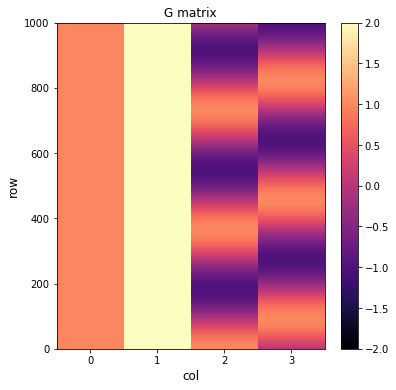

In [33]:
P = 365.25
G = np.zeros((N,M))
G[:,0] = 1
G[:,1] = t
G[:,2] = np.cos(2.*np.pi*t/P)
G[:,3] = np.sin(2.*np.pi*t/P)
fig = plt.figure(figsize=[6,6])
plt.imshow(G,aspect='auto',vmin=-2,vmax=2,cmap='magma')
#plt.imshow(G,aspect='auto',vmin=0,vmax=np.max(t),cmap='magma')
#plt.imshow(G,aspect='auto',vmin=0,vmax=1000)
plt.xticks([0,1,2,3])
plt.xlabel('col',fontsize=12)
plt.ylabel('row',fontsize=12)
plt.title('G matrix')
plt.ylim([0,1000])
plt.colorbar()

###  <font color='red'>Question 5 (10 points) </font> 
#### i) Find the least squares solution using [numpy.linalg.lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html). This function takes the G matrix and the data vector as arguments, and will calculate the least squares solution. As an output, it returns a list of items. The first item in the list is an array of the best fitting model parameters (in this case it will be an array containing $m_1, m_2, m_3$ and $m_4$). (5 pts)

#### ii) What is the value of the slope of the linear trend? *Think about the units!* (5 pts)

In [9]:
sol = np.linalg.lstsq(G,d,rcond=None)
m_est = sol[0]
slope = m_est[1]
print("m_est = {}".format(m_est))
print('The slope of the linear trend is {} C/day'.format(slope))

m_est = [  4.63256953e+00   9.32212502e-05  -3.47920352e-01  -1.29286524e+01]
The slope of the linear trend is 9.32212502045e-05 C/day


###  <font color='red'>Question 6 (10 points) </font> 

#### Plot your model against the observed data. To generate "synthetic" data (i.e., the data that your model predicts), use the equation $\mathbf{d_{pre}} = \mathbf{G} \mathbf{m_{lsq}}$, where $\mathbf{d_{pre}}$ is the predicted data, and $\mathbf{m_{lsq}}$ is the vector containing best fitting model parameters. *Hint*, use np.dot for matrix-vector multiplication. In your plot, make sure to clearly label the axes, and also use a legend to show which data is the observed, and which is the modeled. 

23511


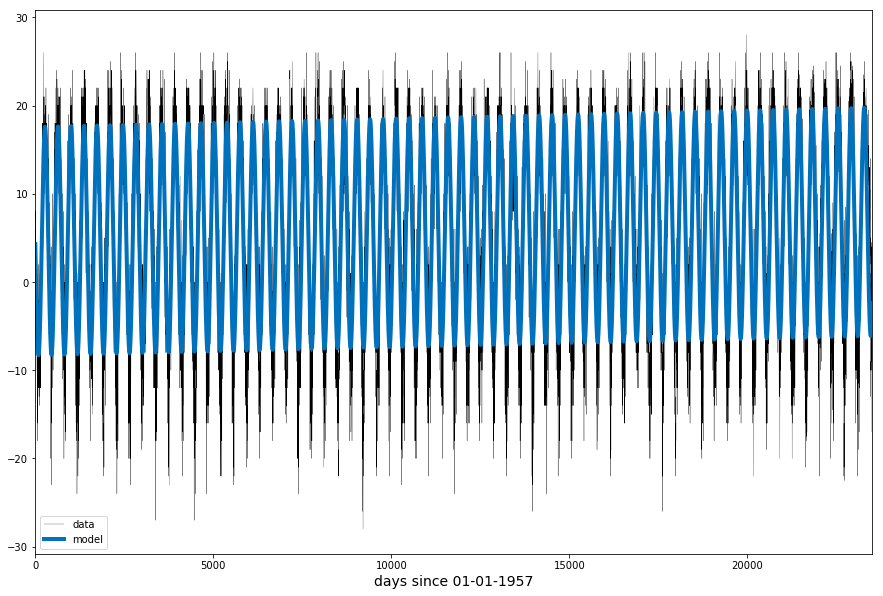

In [16]:
d_pre = np.dot(G,m_est)

fig = plt.figure(figsize=[15,10])
plt.plot(t,d,c='black',linewidth=0.25,label='data')
plt.plot(t,d_pre,c='C0',label='model',linewidth=4)
plt.legend(loc='lower left')
plt.xlabel('days since 01-01-1957',fontsize=14)
plt.xlim([0,np.max(t)])
print(len(d_pre))

## Part 2, individual exercise: Interpretation of the results

###  <font color='red'>Question 7 (10 pts) </font>
#### i) Based on the slope of the linear trend you found, by how approximately much has Hubbard Brook warmed or cooled on average between 1957 and 2020? (5 pts)

#### ii) If the trend continues how much warmer / colder will Hubbard Brook be in 2050? (5 pts)

In [11]:
#part 1
delta_temp = slope*N
print('i) based on our linear trend of {:3.2e} C/day, Hubbard Brook warmed by {:2.2f} C between 1957 and 2020'.format(slope,delta_temp))

#part 2
ndays = (2050 - 2021) * 365.25
delta_temp = slope*ndays
print('ii) if the warming continues, it will be {:2.2f} C hotter in 2050'.format(delta_temp))

i) based on our linear trend of 9.32e-05 C/day, Hubbard Brook warmed by 2.19 C between 1957 and 2020
ii) if the warming continues, it will be 0.99 C hotter in 2050


### <font color='red'>Question 8 (20 pts) </font>

#### Often, we would like some statistical measure of how well our model is fitting the data. This is usually done by analyzing the "error" ($\epsilon$) of your model, which can be thought of as the difference between the model predictions and the data (i.e., $\epsilon = \mathbf{d} - \mathbf{d_{pre}}$ ). One common measure of the error is the root-mean-square error (RMSE) which is given as

$ \mathrm{RMSE} = \sqrt{\left(\overline{\mathbf{d} - \mathbf{d_{pred}}}\right)^2} $

#### i) Calculate the RMSE of your best fitting model (10 pts)

#### ii) Caclulate a new linear least squares solution, but excluding the the linear trend term. i.e., your model will be described as

$d_{i} = m_1\cos(2 \pi t_{i}/P) + m_2\sin(2 \pi t_{i}/P) $

#### How does the error compare to the previous best fitting model? What does this tell you about the importance of the linear trend? (10 pts)

In [12]:
rms_err = np.sqrt(np.mean((d-d_pre)**2))
print('i) the RMSE of the best fitting model is {:2.2f} C'.format(rms_err))

i) the RMSE of the best fitting model is 4.72 C


In [13]:
P = 365.25
G_new = np.zeros((N,2))
G_new[:,0] = np.cos(2.*np.pi*t/P)
G_new[:,1] = np.sin(2.*np.pi*t/P)
sol_new = np.linalg.lstsq(G_new,d,rcond=None)
m_est_new = sol_new[0]
d_pre_new = np.dot(G_new,m_est_new)
rms_err_new = np.sqrt(np.mean((d-d_pre_new)**2))
print('ii) the RMSE of the model with no linear trend is {:2.2f} C, which shows that \
including the warming trend fits the data better'.format(rms_err_new))

ii) the RMSE of the model with no linear trend is 7.45 C, which shows that including the warming trend fits the data better
